# Ames House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [1]:
import sklearn
from sklearn.model_selection import cross_validate
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.stats import norm
pd.set_option('display.max_rows', 1000)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.pipeline import make_pipeline

In [2]:
train_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/home-data-for-ml-course/train.csv")
test_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/home-data-for-ml-course/test.csv")

train = train_raw.copy()
test = test_raw.copy()

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

print(f'Size of training data - {len(train_raw)}')
print(f'Size of test data - {len(test_raw)}')
print(f'No. of features - {len(test_raw.columns)}')

train_raw

Size of training data - 1460
Size of test data - 1459
No. of features - 80


Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0        1          60       RL  ...        WD         Normal    208500
1        2          20       RL  ...        WD         Normal    181500
2        3          60       RL  ...        WD         Normal    223500
3        4          70       RL  ...        WD        Abnorml    140000
4        5          60       RL  ...        WD         Normal    250000
...    ...         ...      ...  ...       ...            ...       ...
1455  1456          60       RL  ...        WD         Normal    175000
1456  1457          20       RL  ...        WD         Normal    210000
1457  1458          70       RL  ...        WD         Normal    266500
1458  1459          20       RL  ...        WD         Normal    142125
1459  1460          20       RL  ...        WD         Normal    147500

[1460 rows x 81 columns]

# I am using the true values for the test dataset for testing purpose. Do not train the model on test data. This is just for validating model's performance, not to get a better score.

In [3]:
cheat = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/home-data-for-ml-course/submission_cheat.csv")
y_true = cheat['SalePrice']
len(y_true)

1459

# Plot all the features

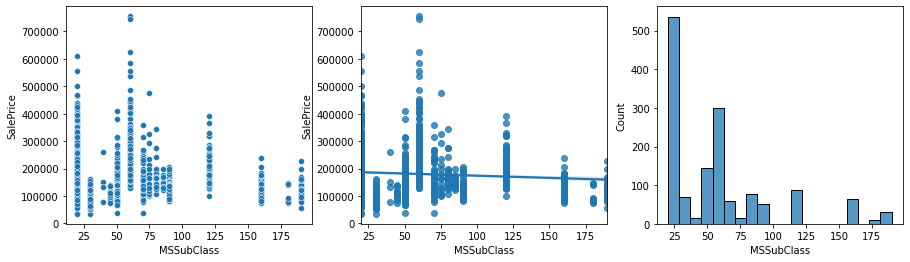

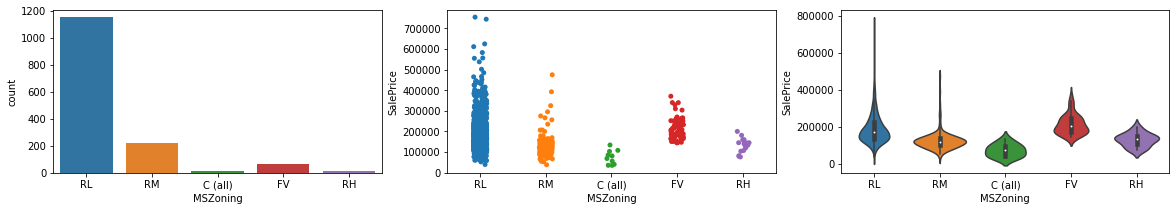

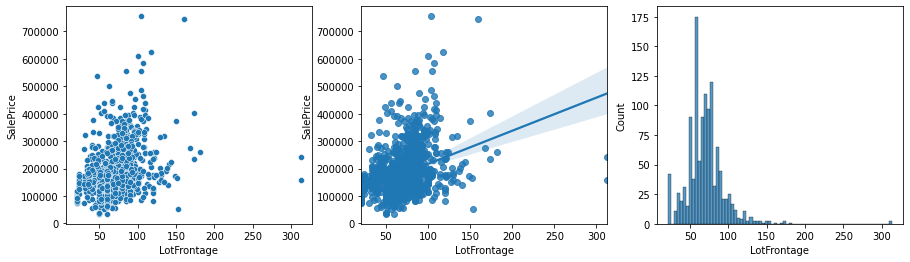

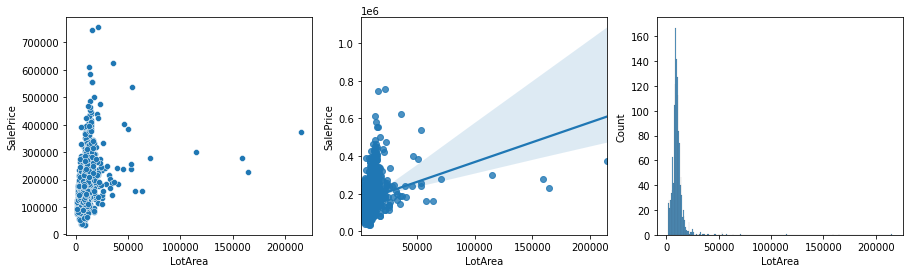

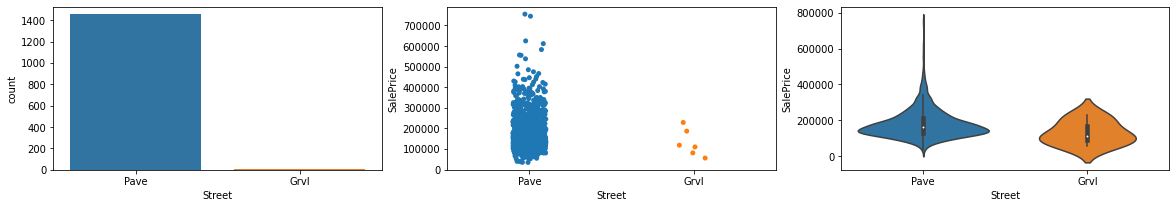

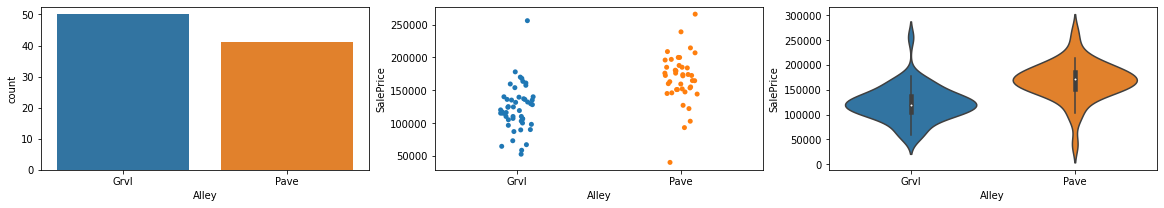

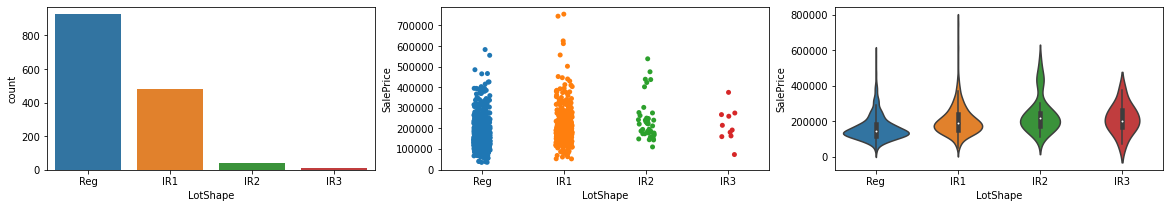

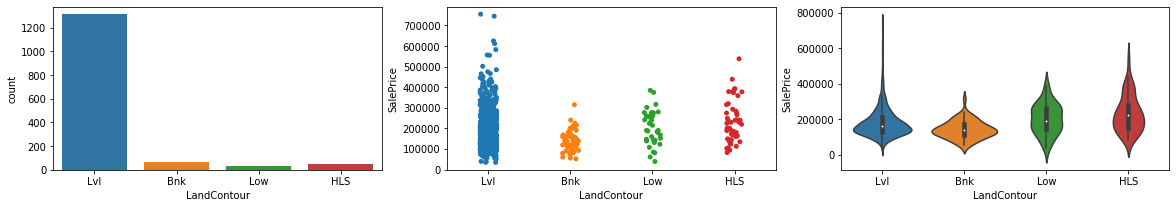

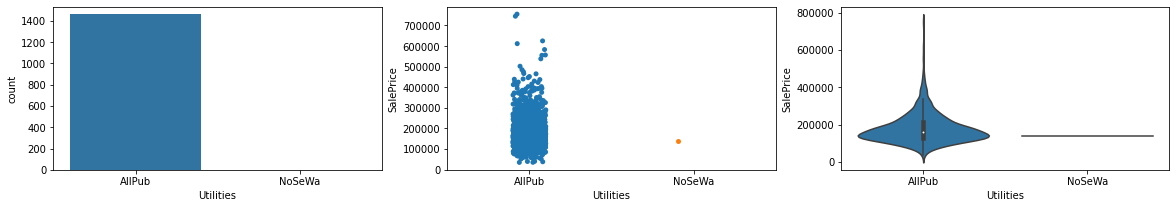

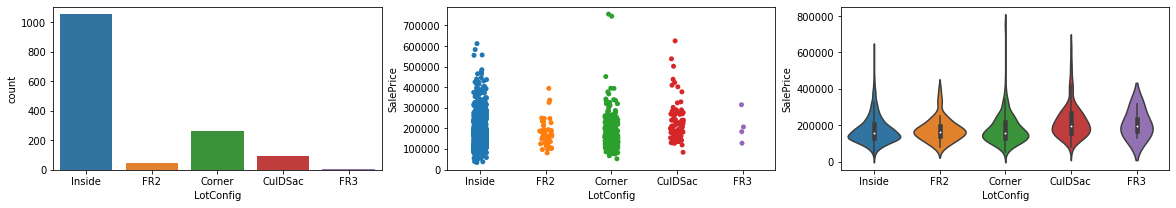

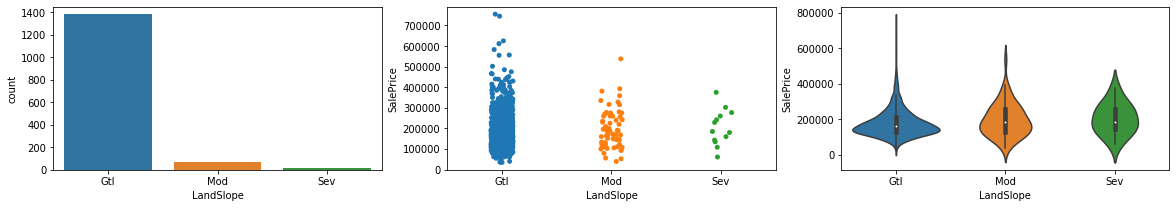

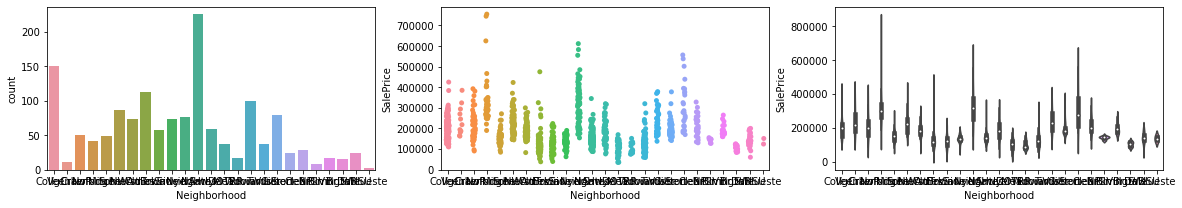

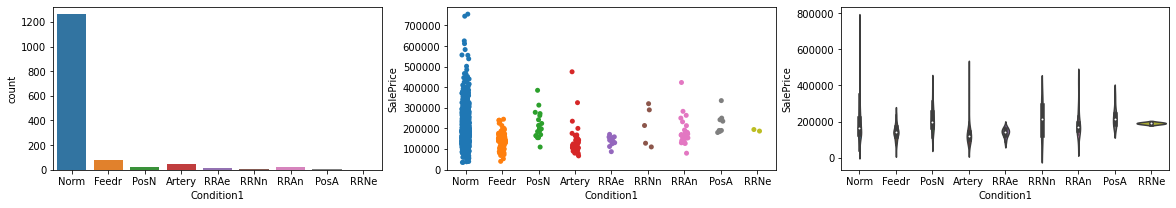

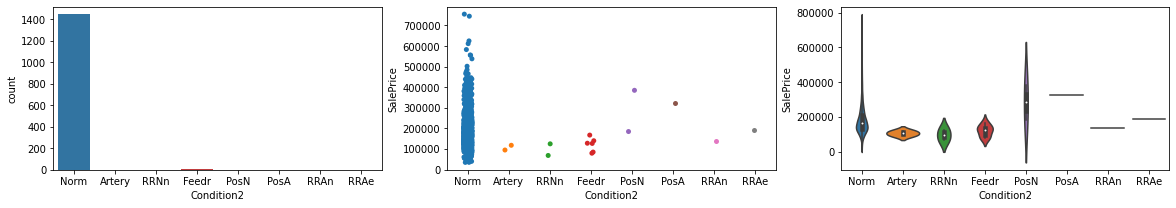

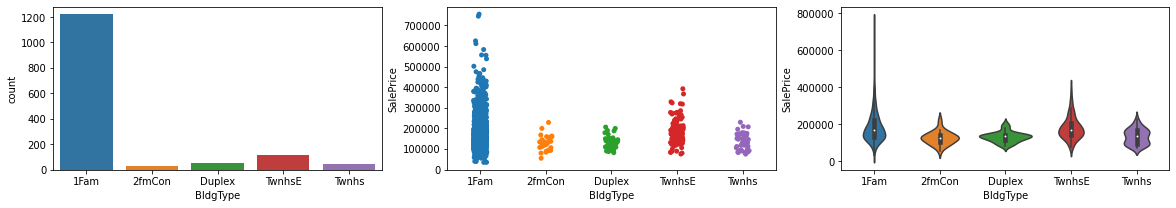

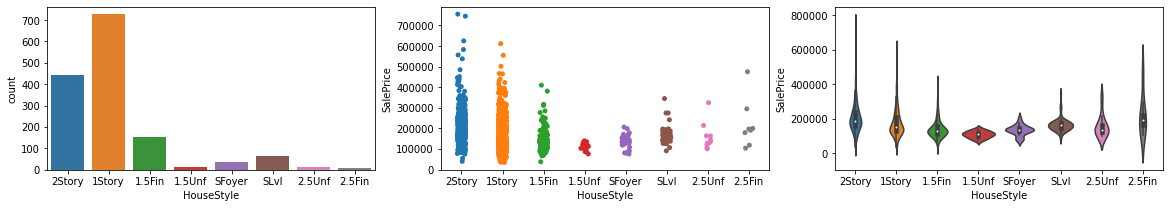

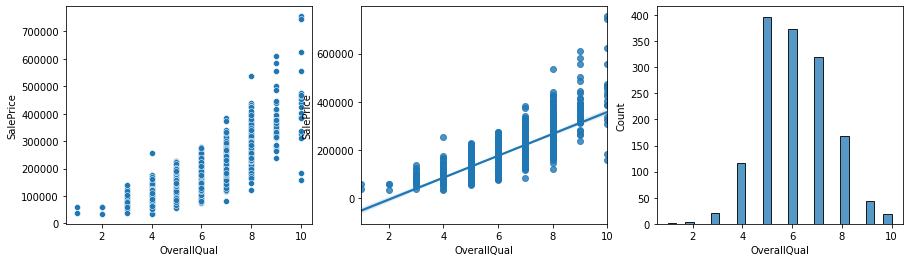

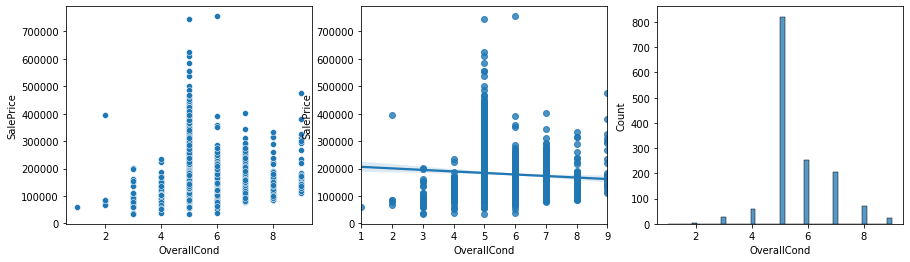

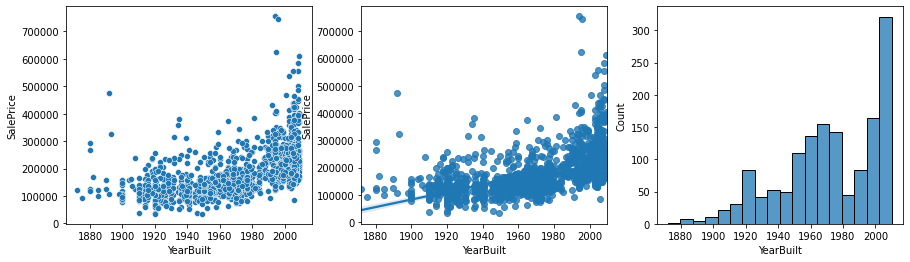

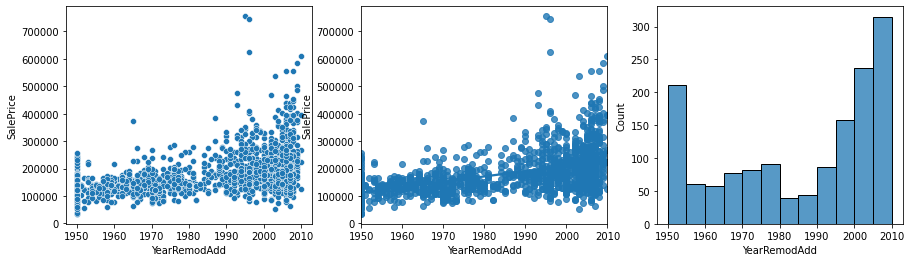

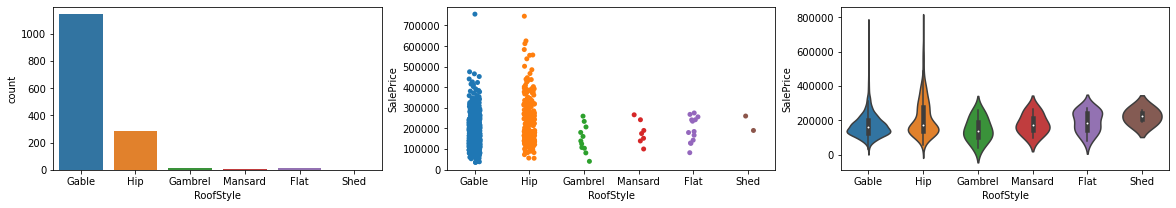

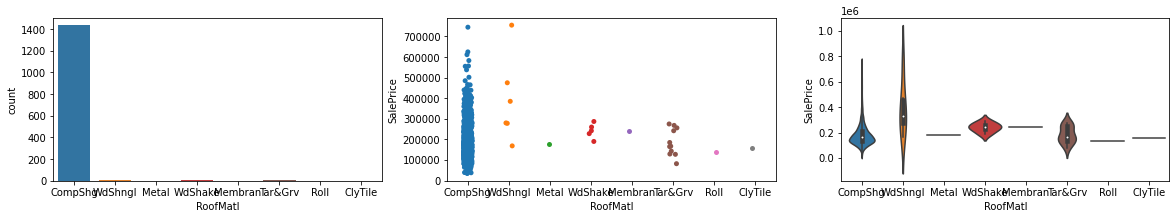

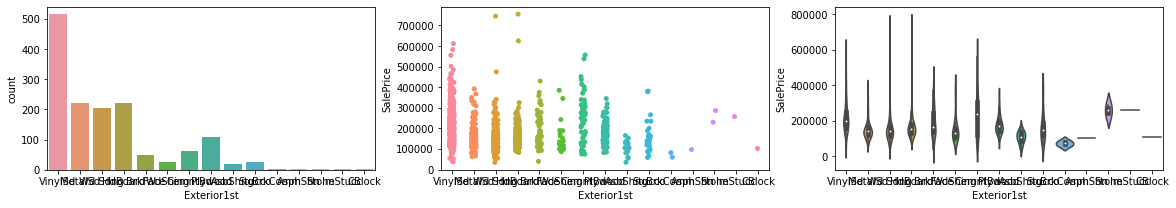

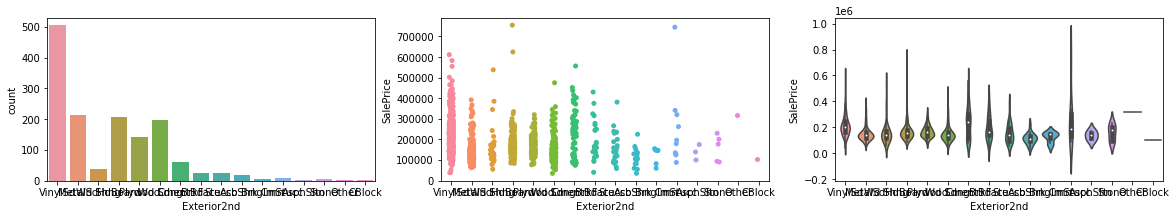

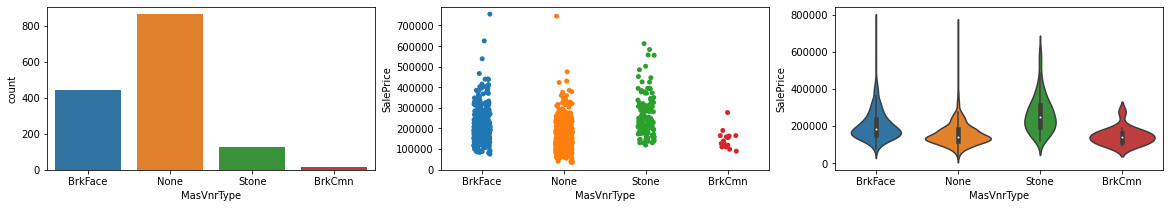

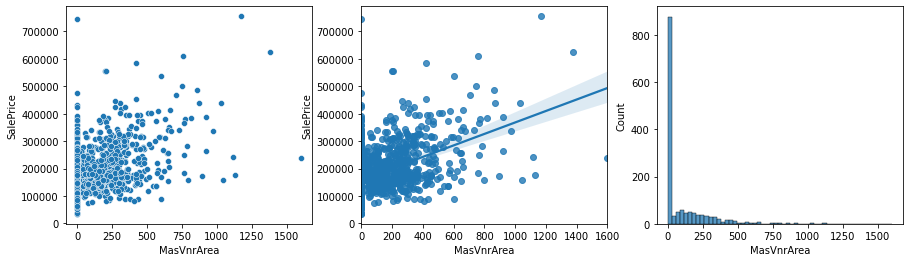

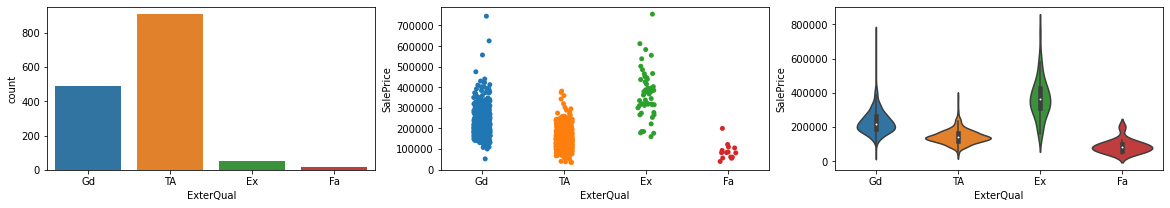

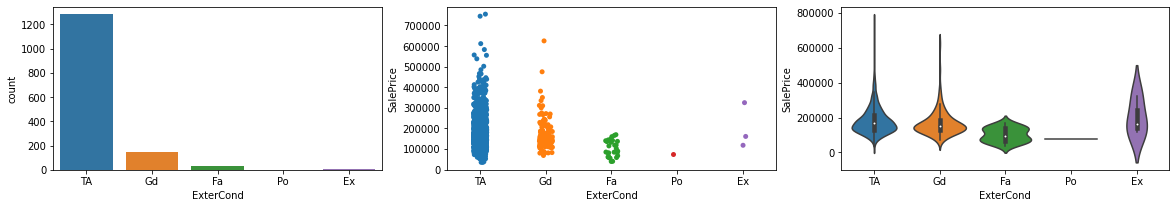

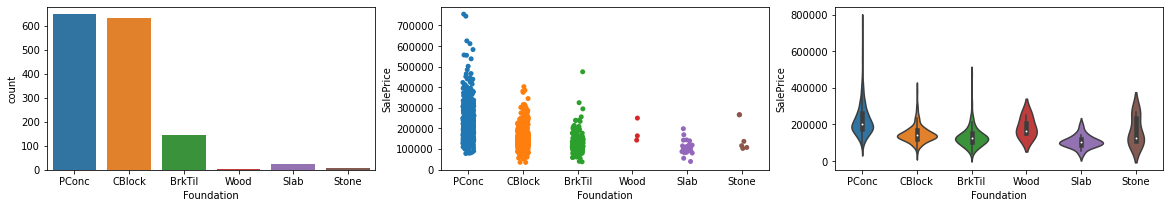

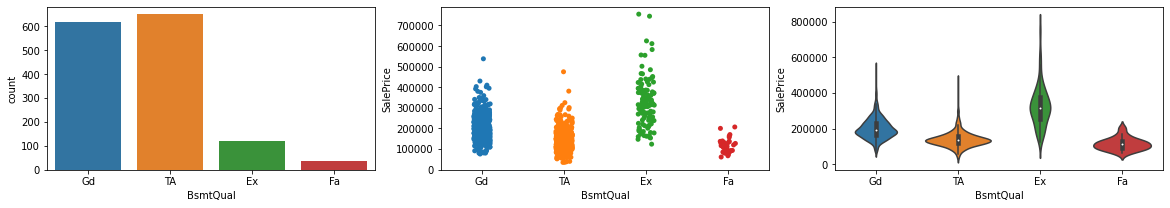

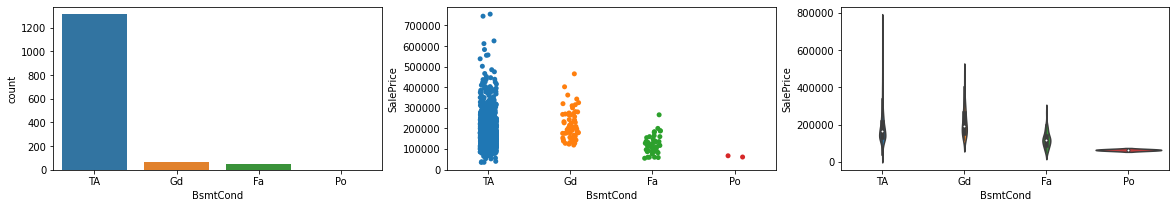

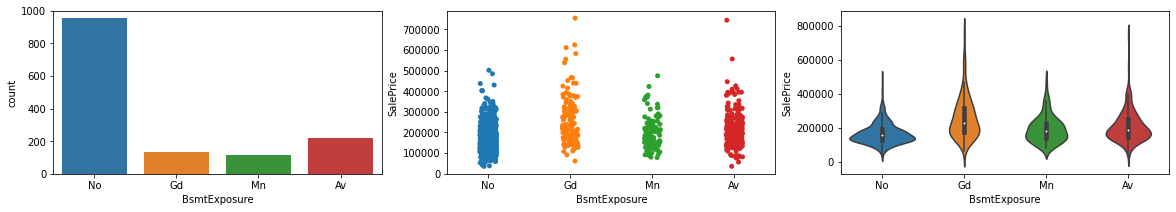

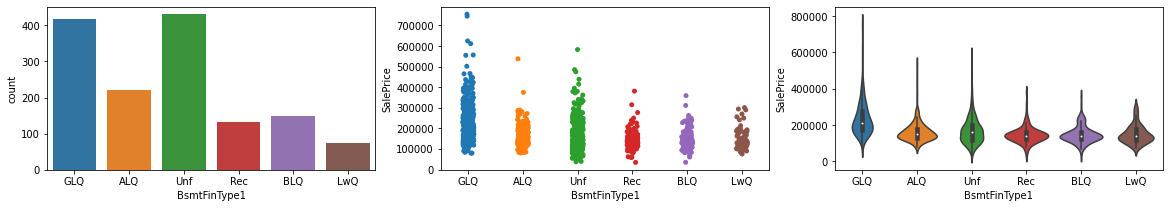

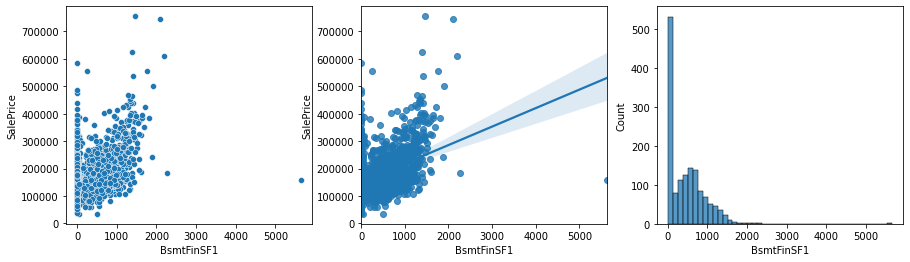

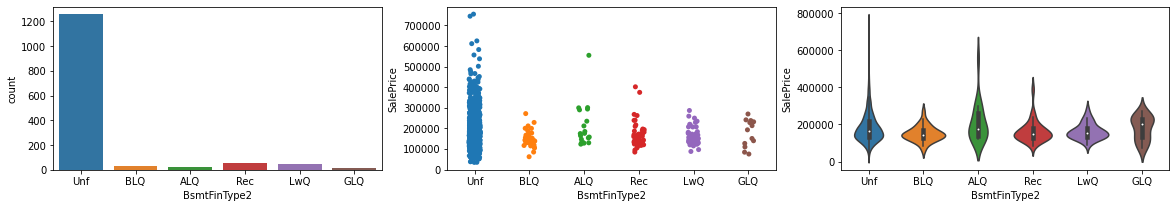

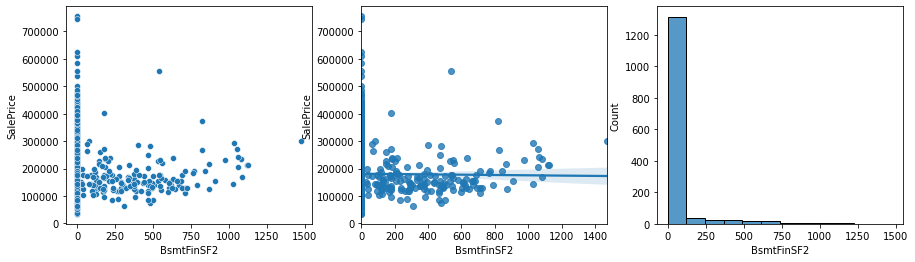

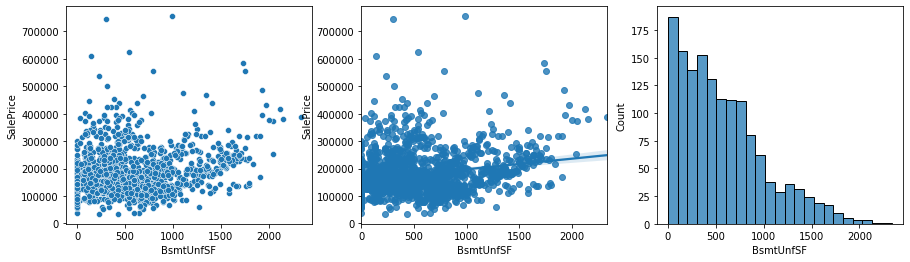

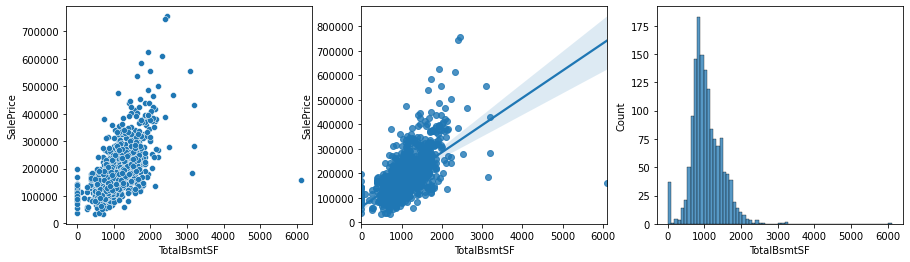

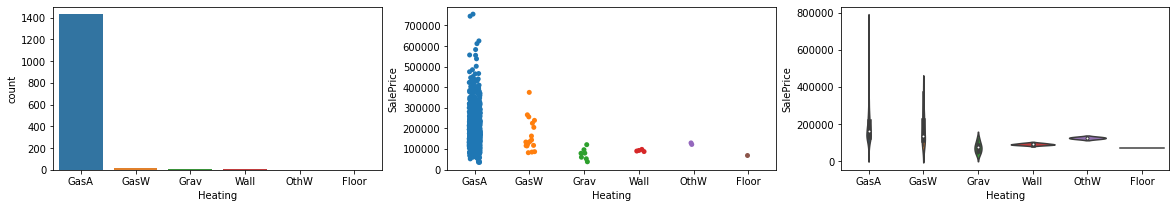

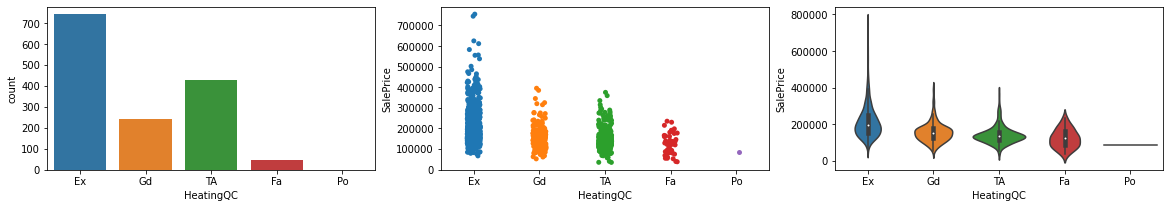

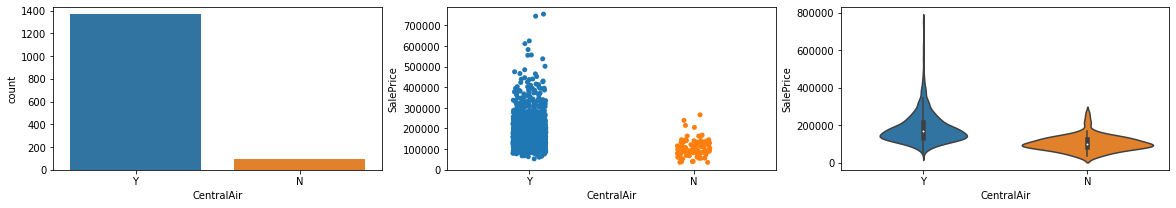

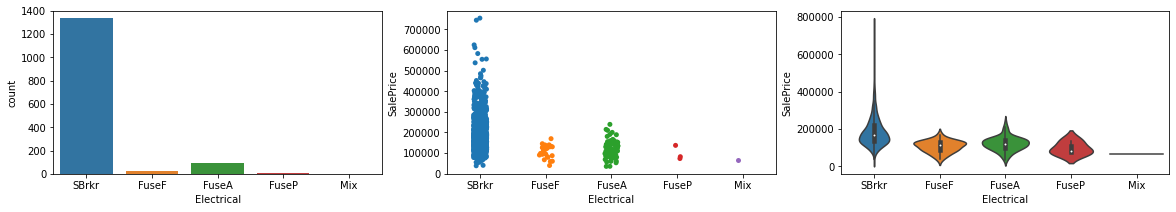

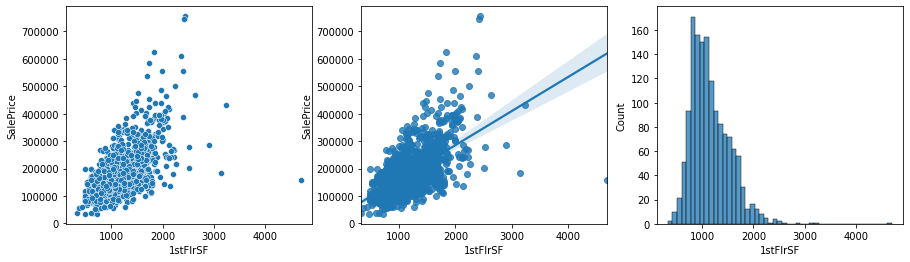

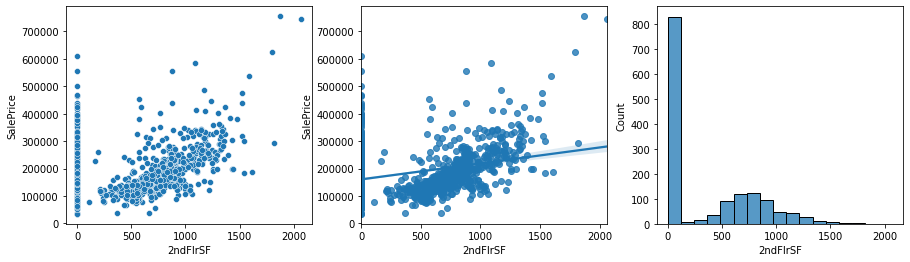

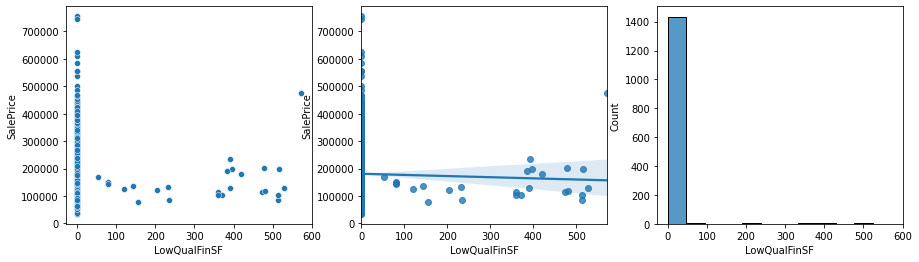

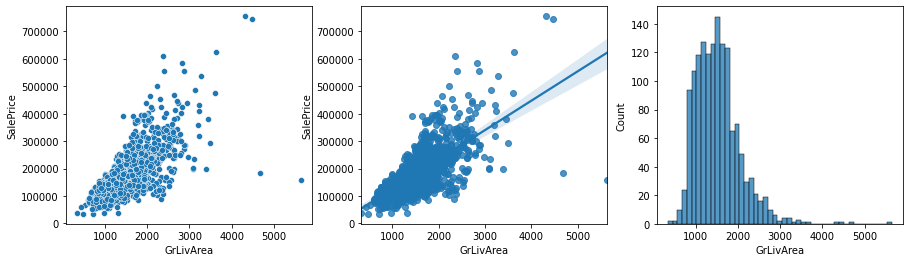

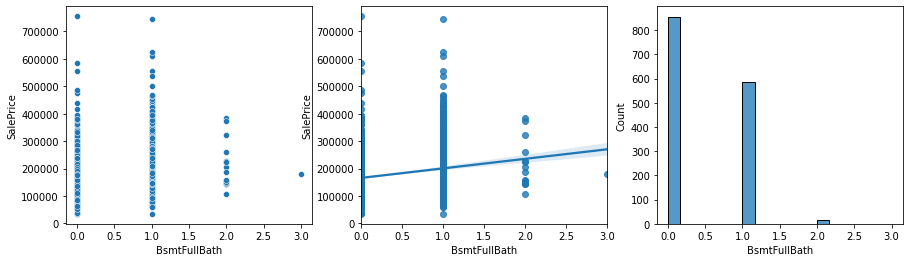

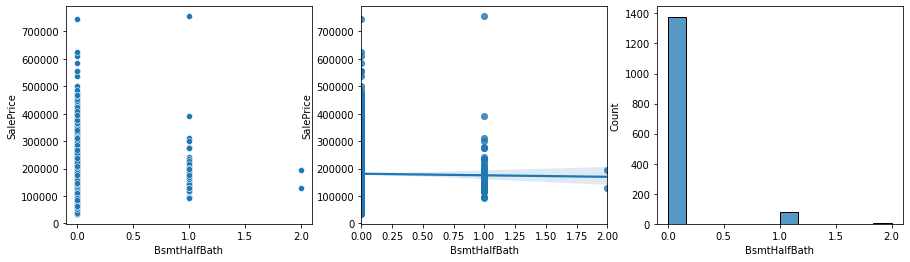

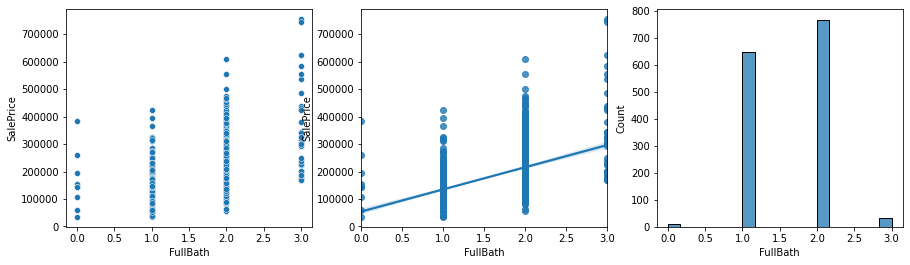

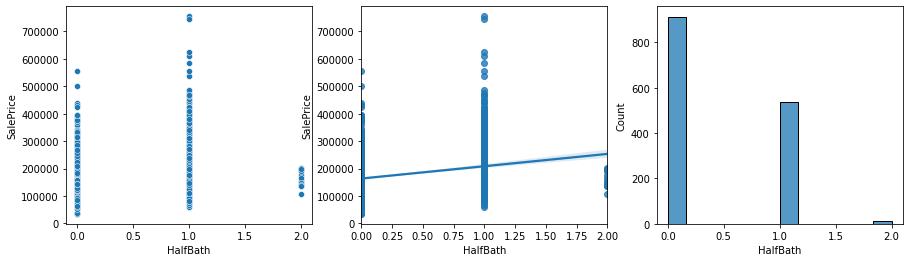

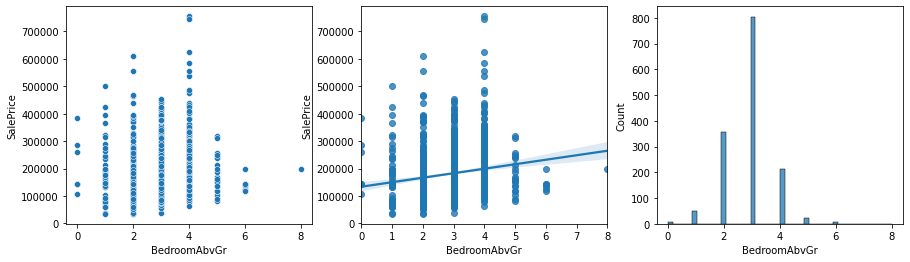

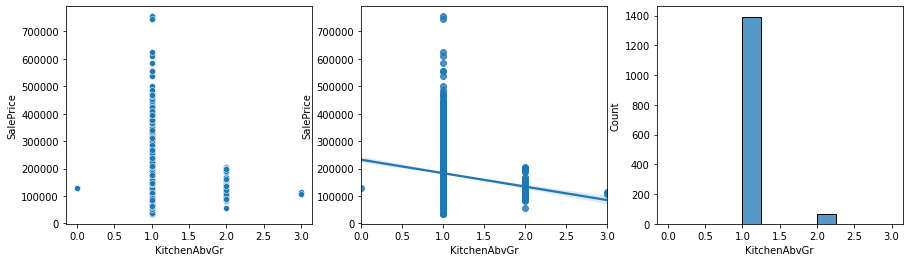

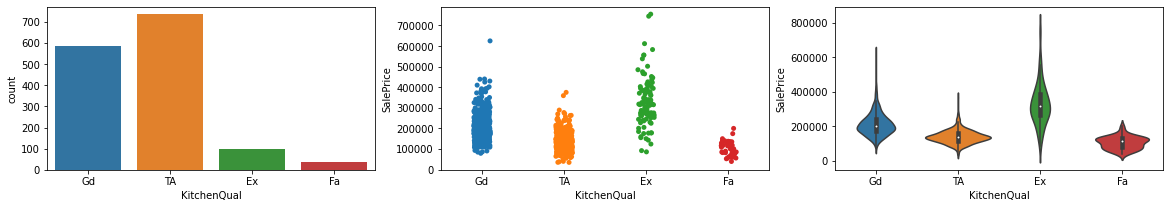

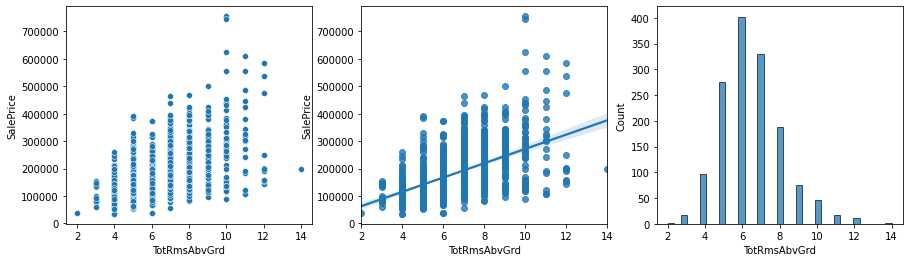

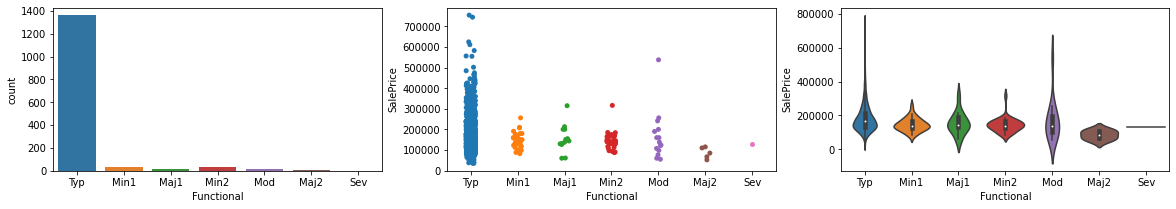

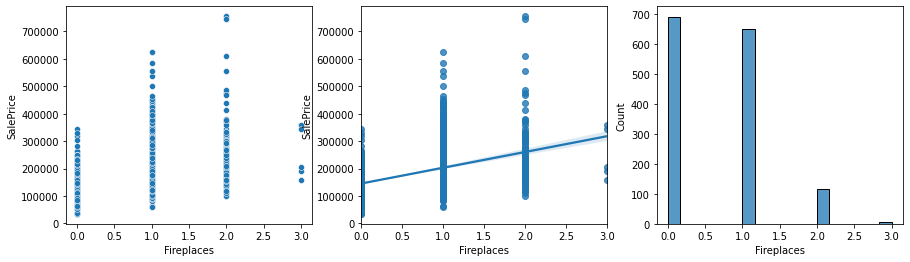

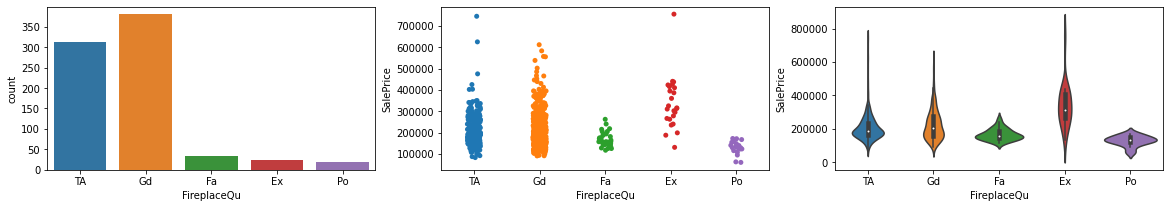

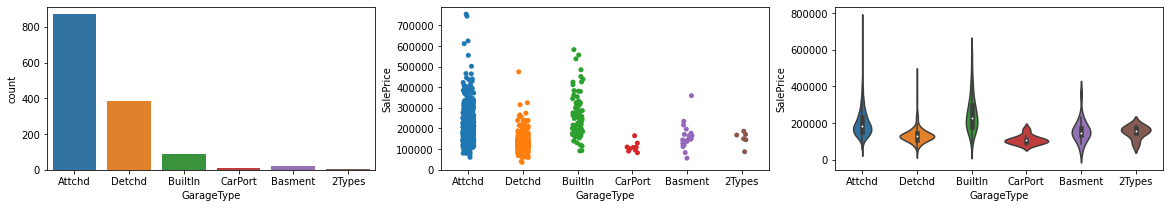

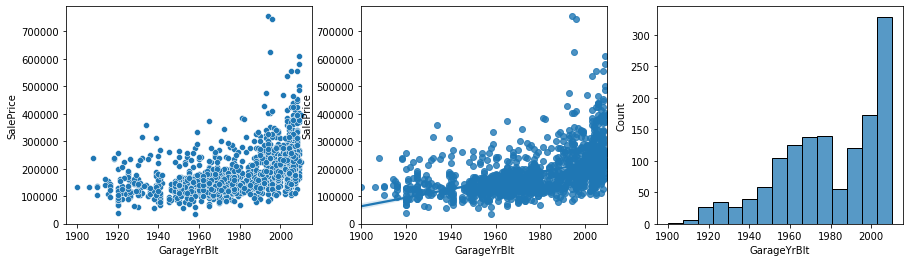

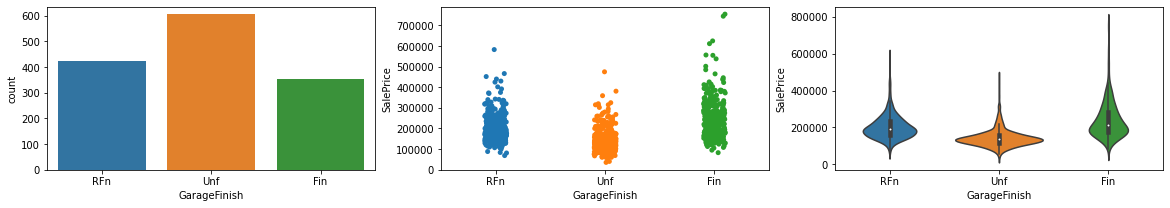

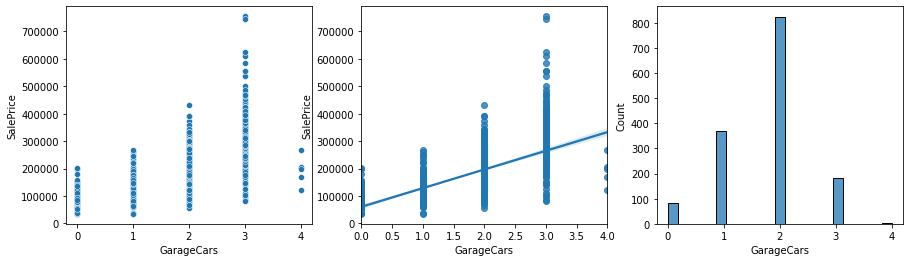

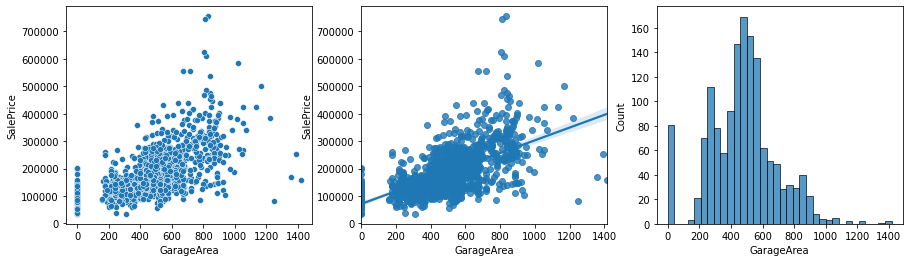

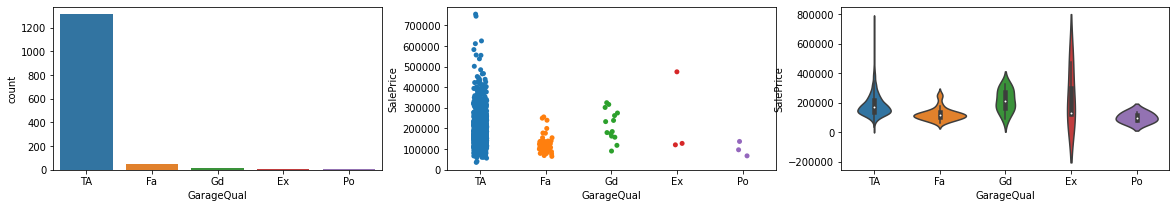

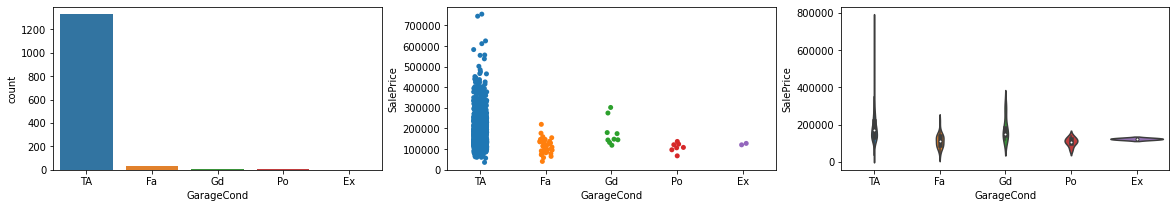

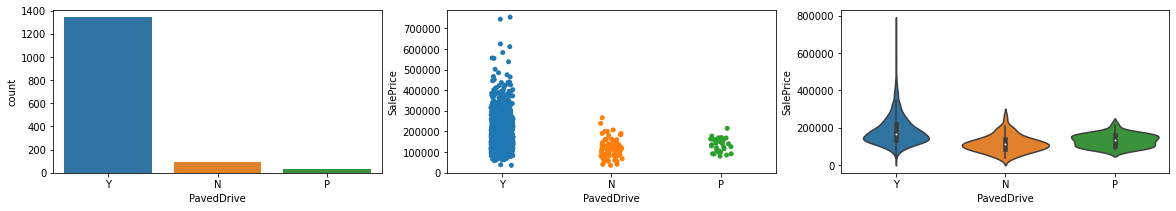

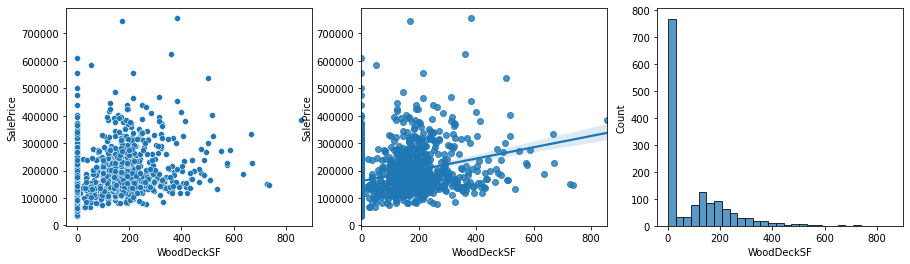

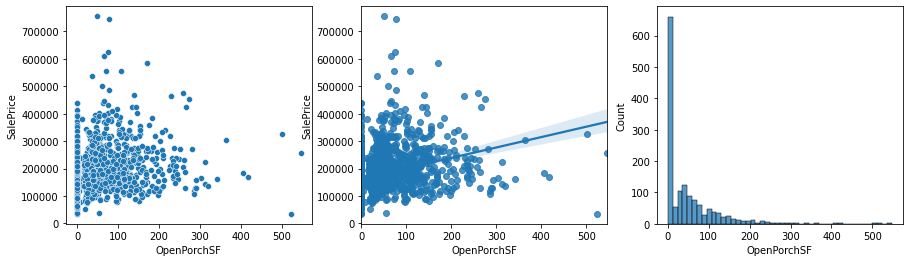

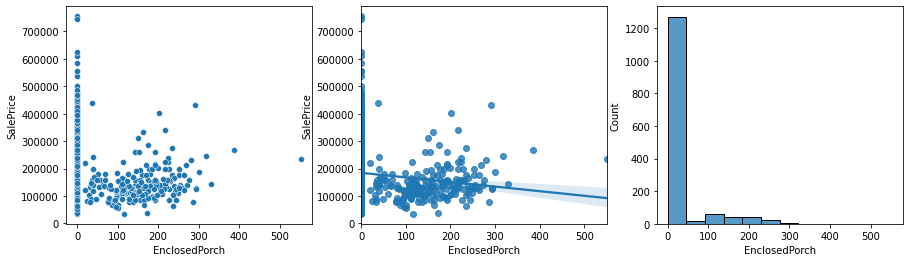

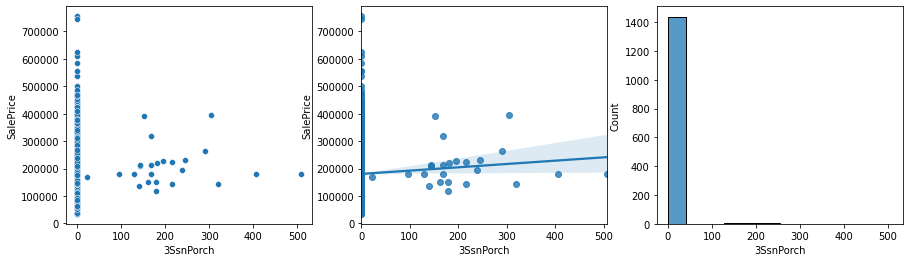

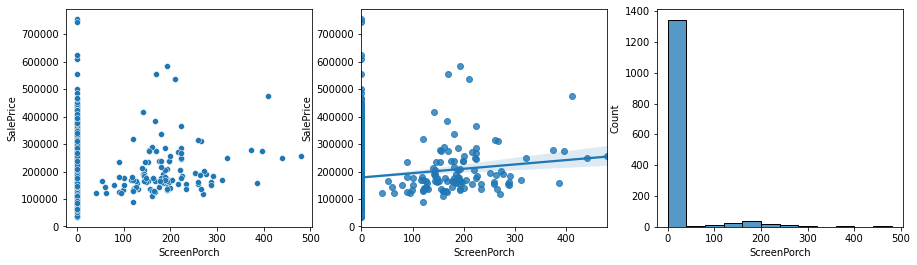

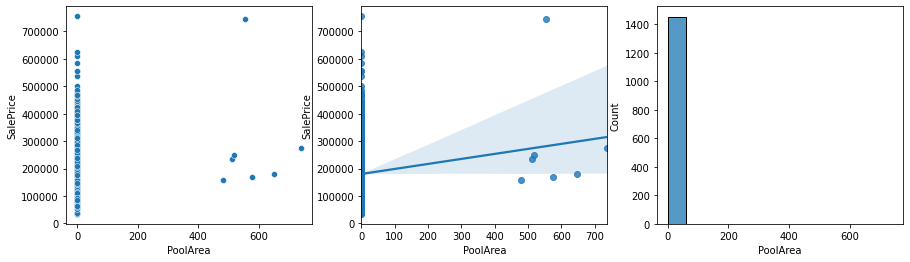

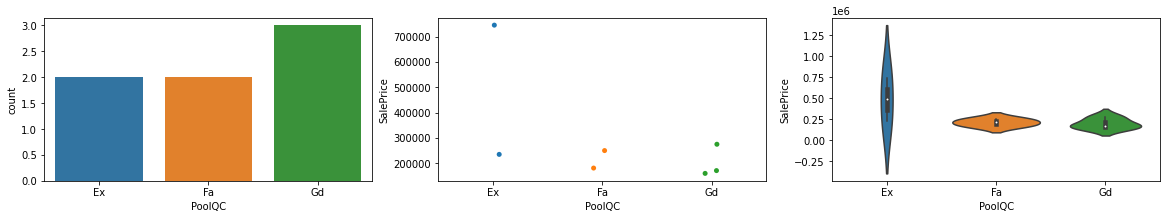

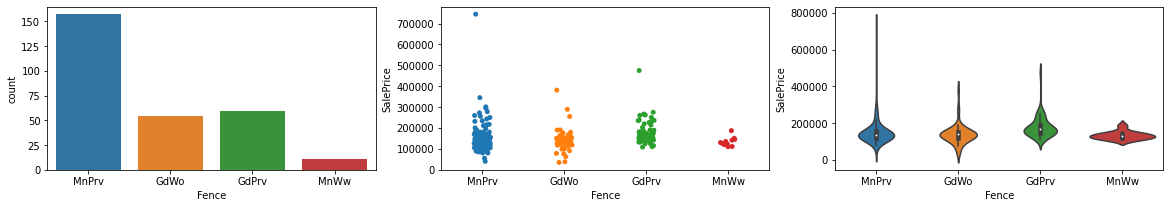

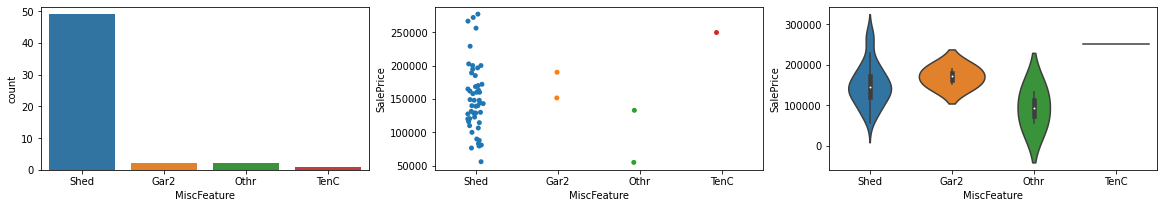

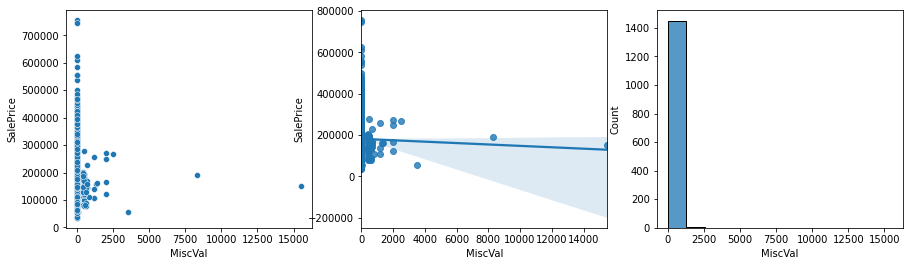

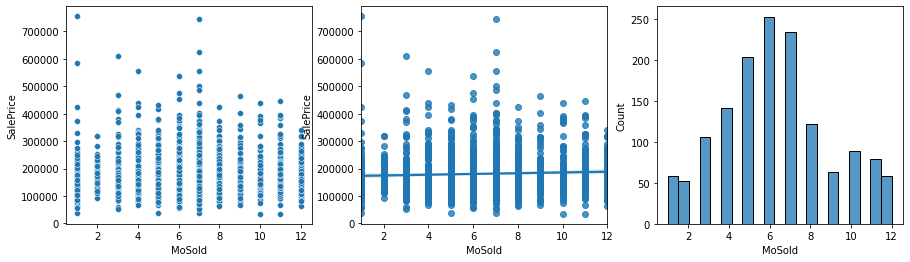

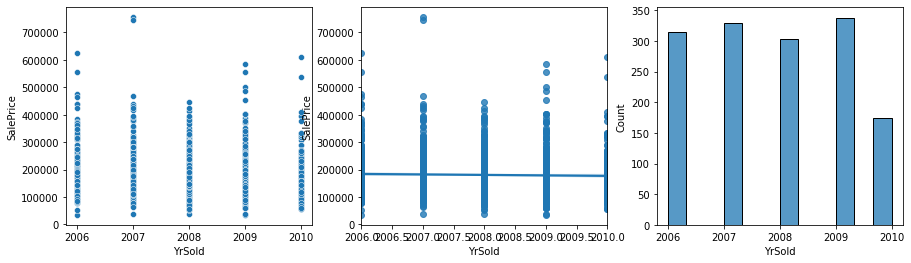

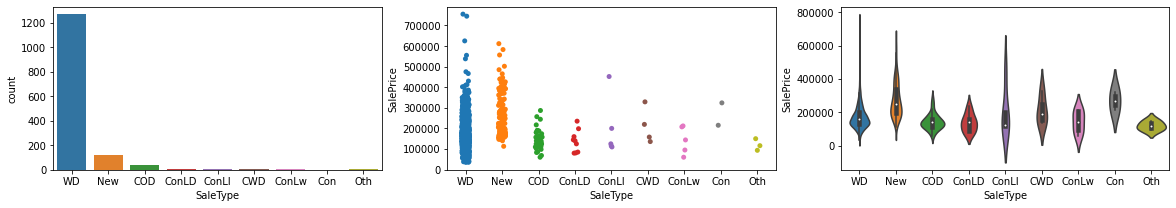

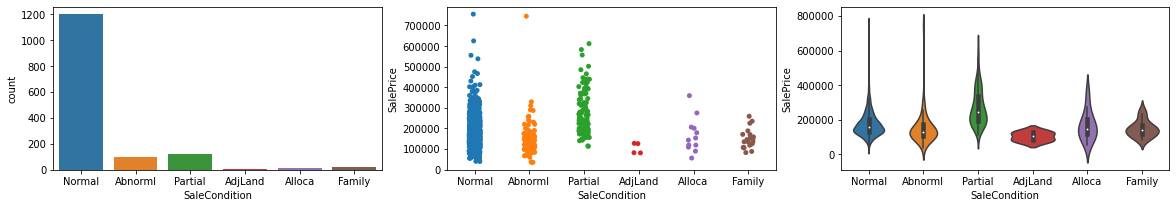

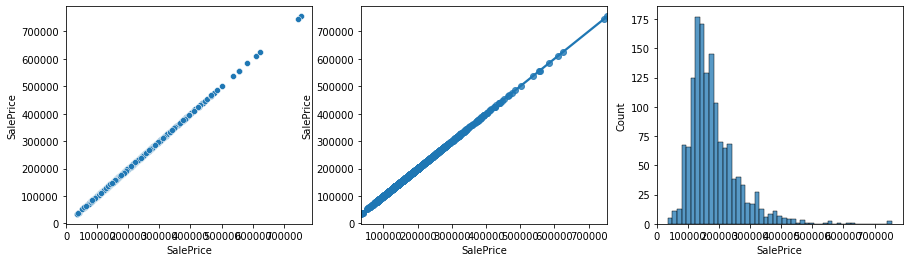

In [ ]:
for feature in train.columns:

  if train[feature].dtype!=object:
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    sns.scatterplot(x=feature, y='SalePrice',data=train, ax=ax[0])
    sns.regplot(x=feature, y='SalePrice',data=train, ax=ax[1])
    sns.histplot(train[feature], ax=ax[2])
    plt.show()

  elif train[feature].dtype==object:
    fig, ax = plt.subplots(1,3, figsize=(20,3))
    sns.countplot(x=feature, data=train, ax=ax[0])
    sns.stripplot(x=feature, y='SalePrice',data=train, ax=ax[1])
    sns.violinplot(x=feature, y='SalePrice',data=train, ax=ax[2])
    plt.show()

# Data Correlation

The 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' saying a big 'Hi!', but we can also see many other variables that should be taken into account. That's what we will do next.

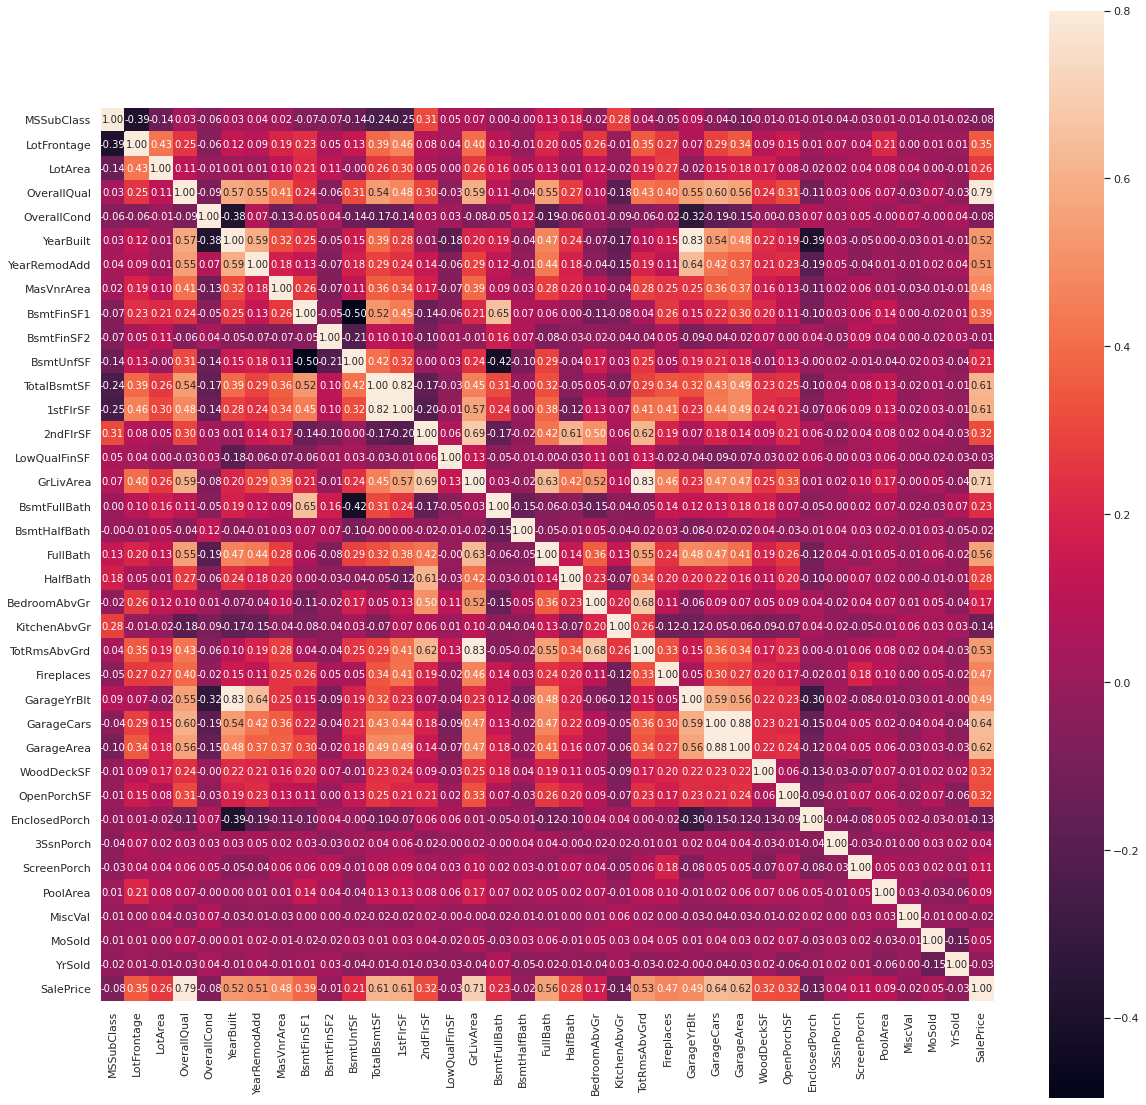

In [4]:
corrmat = train.corr()
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', annot_kws={'size': 10},)
plt.show()

# Visualizing Null Value Percentage

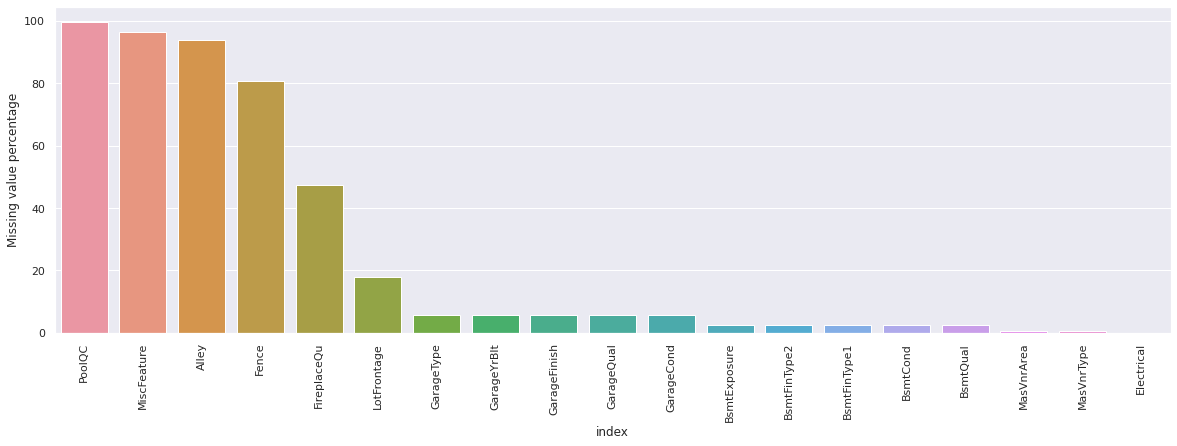

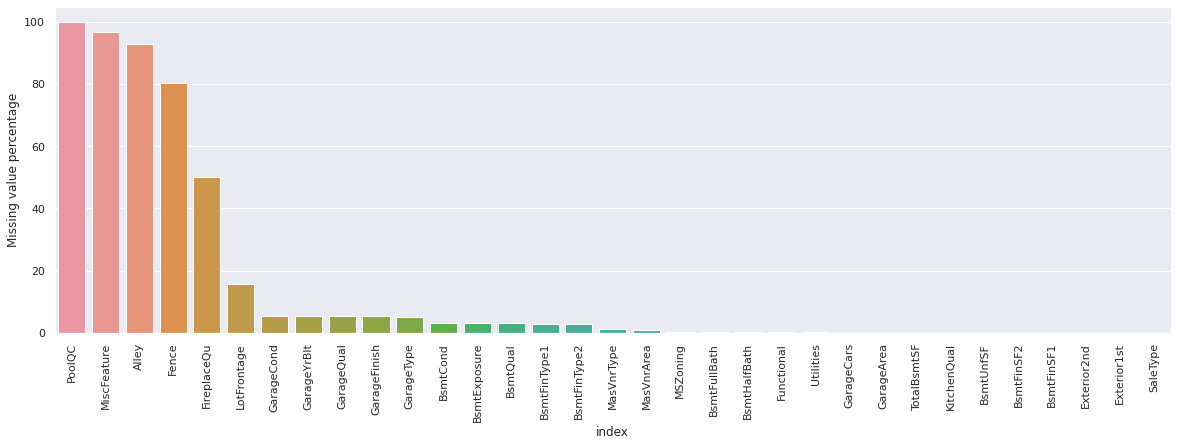

In [5]:
def null_value_percentage(dataframe):
  # dataframe = pd.concat([dataframe1, dataframe2], axis =0)
  columns = [column for column in dataframe.columns if dataframe[column].isna().sum()>0]
  percentage_list = [(dataframe[column].isna().sum()/len(dataframe)*100) for column in dataframe.columns if dataframe[column].isna().sum()>0]
  percentage_df = pd.DataFrame({'index':columns, 'Missing value percentage':percentage_list})
  percentage_df.sort_values(by=['Missing value percentage'], ascending=False, inplace=True)
  fig, ax = plt.subplots(1,1, figsize=(20,6))
  sns.barplot(x=percentage_df['index'], y=percentage_df['Missing value percentage'], ax=ax)
  plt.xticks(rotation='90')

null_value_percentage(train_raw)
null_value_percentage(test_raw)

# Imputing Missing Values

Let's analyse this to understand how to handle the missing data.

1. According to data dexcription, there are some feature where the missing values are to be replaced with `'None'` because in these features cases null value means not present e.g. GaragaFinish-null value means there is no garage. These features are: 
`'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'MiscFeature', 'Alley', 'Fence'` .

2.  Replacing missing data with 0 e.g. TotalBsmtSF-null value means 0 squarefeet.
`'GarageCars', 'GarageArea', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'`

3. There are features that can have strong relationship with other features and can be imputed accordingly. Like, the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median `'LotFrontage'` of the eighborhood. 

4. Categorical features with missing value percentage less than 10% can be replaced with their mode value. 
`'Electrical', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'`

5. We are not dropping any features here even though some of them have a higher percentage of missing value. 

There are no missing values left anymore.

In [ ]:
dataset = [train, test]

# Working with missing values
for df in dataset:

  # More than 50% missing values
  # df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True) 

  #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
  df['LotFrontage'] = df.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))
  df['MSZoning'] = df.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

  # Features where missing value means 'None' i.e. GaragaFinish-null value means there is no garage
  for feature in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                  'BsmtQual', 'BsmtCond', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']:
    df[feature].fillna('None', inplace=True)

  # Features where missing value means 0 i.e. TotalBsmtSF-null value means 0 squarefeet
  for feature in ['GarageCars', 'GarageArea', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                  'BsmtFullBath', 'BsmtHalfBath']:
    df[feature].fillna(0, inplace=True)

  # Rest of the features- replace with the highest frequency value
  for feature in ['Electrical', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    df[feature].fillna(df[feature].mode()[0], inplace=True)

  null_col = [col for col in df.columns if df[col].isna().sum()>0]
  print(f'{null_col} contains null values')

[] contains null values
[] contains null values


# Removing Outliers

## Univariate Analysis (e.g. IQR)
Say, looking at the feature ground living area (GrLivArea) we can say that there are some outliers. As the data is skewed we can use inter quantile range (IQR) method to get rid of outliers. 

Applying IQR we can see that there are 31 outliers. We can't just drop them. The training dataset has only 1460 entries. Dropping 31 entries could have a great impact on the performance of prediction models. So what I do here is handpick the extreme outliers and remove them manually. 

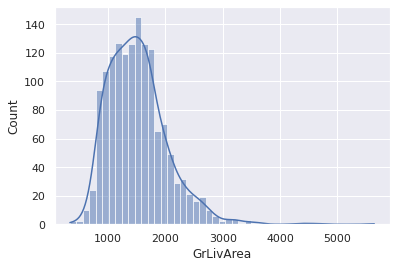

Q1 - 1129.5, Q2(median) - 1464.0, Q3 - 1776.75
Inter quantile range (IQR) - 647.25
Lower ourlier gate - 158.625, Upper ourlier gate - 2747.625
31 outliers
[58, 118, 185, 197, 231, 304, 324, 496, 523, 583, 608, 635, 691, 769, 798, 803, 961, 1024, 1031, 1046, 1142, 1169, 1173, 1175, 1182, 1268, 1298, 1312, 1328, 1353, 1386]


In [ ]:
sns.histplot(train['GrLivArea'], kde=True)
plt.show()

q1, q2, q3 = np.percentile(train['GrLivArea'], 25), np.percentile(train['GrLivArea'], 50), np.percentile(train['GrLivArea'], 75)
print(f'Q1 - {q1}, Q2(median) - {q2}, Q3 - {q3}')

iqr = q3-q1
print(f'Inter quantile range (IQR) - {iqr}')
lower_gate, upper_gate = (q1 - 1.5 * iqr), (q3 + 1.5 * iqr)
print(f'Lower ourlier gate - {lower_gate}, Upper ourlier gate - {upper_gate}')

outlier_indices = [i for i,value in enumerate(train['GrLivArea']) if value<lower_gate or value>upper_gate]
print(f'{len(outlier_indices)} outliers')
print(outlier_indices)

## Bivariate Analysis

Applying IQR we can see that there are 31 outliers. We can't just drop them. The training dataset has only 1460 entries. Dropping 31 entries could have a great impact on the performance of prediction models. So what I do here is handpick the extreme outliers and remove them manually. 

For example, from the bivariate analysis of GrLivArea/SalePrice we can see that, there are 2 points houses with GrLivArea more than 4000 sq.ft. but their price is lower than 200k. These are anomalies and can be removed. 

Analysing the feature TotalBsmtSF w.r.t SalePrice we can see some extreme outlier points and can eliminate them.



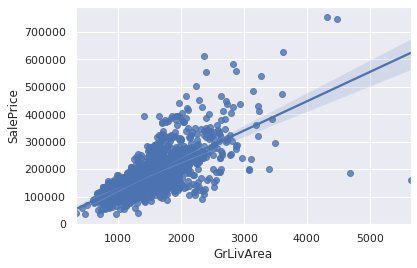

In [6]:
sns.regplot(x='GrLivArea', y='SalePrice', data=train)
plt.show()

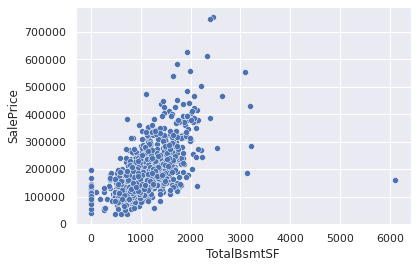

In [7]:
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train)
plt.show()

In [ ]:
# outlier_indices = [1298, 523, 30, 462, 588, 632, 1324]
outlier_indices = [1298, 523]
train = train.drop(train.index[outlier_indices])

print(f'Dropped {1460-len(train)} entries from the training set \nRemaining entries: {len(train)}')

Dropped 2 entries from the training set 
Remaining entries: 1458


# Advanced Feature Engineering


Let's first concatenate the train and test data in the same dataframe. Then do the following:

1. Converting ORDINAL categorical features to numerical values i.e. Label Encoding. For example, the feature "ExterQual" is ordinal.  
` {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}` .

 Another feature "BsmtFinType1" 
` {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}`

2. Converting feature that are actually categorical `'YrSold', 'MoSold' & 'MSSubClass'`

3. Creating/Adding new numerical important feature columns.

```
'TotalSF' = '1stFlrSF'+ '2ndFlrSF'+ 'TotalBsmtSF'
'TotalPorchSF' = '3SsnPorch'+ 'OpenPorchSF']+ 'EnclosedPorch']+ 'ScreenPorch'+ 'WoodDeckSF'
'TotalBathrooms' = 'FullBath'] + (0.5 * 'HalfBath') + 'BsmtFullBath' + (0.5 * 'BsmtHalfBath')
'Age' = 'YrSold' - 'YearBuilt'
'RemodAge' = 'YrSold' - 'YearRemodAdd'
```

4. Creating simple booolean features like if the house has a pool or not, has a fireplace or not, features like that.

5. Dropping insignificant features like 'Utilities'. For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

6. Removing columns that have 99.9% 0 values.



In [12]:
y = list(train['SalePrice'])
train.drop(['SalePrice'], axis=1, inplace=True)

combined_df = pd.concat([train, test], axis = 0, ignore_index=True)
print(len(combined_df))
# combined_df.to_csv('combined_df.csv')
print(f'Number of features columns before feature Engineering: {len(combined_df.columns)}')

# Converting ORDINAL categorical features to numerical
combined_df.replace({"BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
            "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
            "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
            "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
            "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
            "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
            'BsmtExposure' : {"None" : 0, "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
            "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
            "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},            
            'FireplaceQu' : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
            'PoolQC' : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
            "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
            "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}, 
            'CentralAir' : {'Y': 1, 'N': 0}}, inplace=True)

# Converting feature that are actually categorical
combined_df['MSSubClass'] = combined_df['MSSubClass'].astype(object)
combined_df['YrSold'] = combined_df['YrSold'].astype(object)
combined_df['MoSold'] = combined_df['YrSold'].astype(object)

# Merging quality and conditions
combined_df['TotalExterQual'] = combined_df['ExterQual']*combined_df['ExterCond']
combined_df['TotalBsmtQual'] = combined_df['BsmtQual']*combined_df['BsmtCond']
combined_df['TotalGarageQual'] = combined_df['GarageQual']*combined_df['GarageCond']
combined_df['TotalOverallQual'] = combined_df['OverallQual']*combined_df['OverallCond']

# Creating new numerical important feature columns
combined_df['TotalSF'] = combined_df['1stFlrSF']+combined_df['2ndFlrSF']+combined_df['TotalBsmtSF']
combined_df['TotalPorchSF'] = combined_df['3SsnPorch']+combined_df['OpenPorchSF']+combined_df['EnclosedPorch']+combined_df['ScreenPorch']+combined_df['WoodDeckSF']
combined_df['TotalBathrooms'] = combined_df['FullBath'] + (0.5 * combined_df['HalfBath']) + combined_df['BsmtFullBath'] + (0.5 * combined_df['BsmtHalfBath'])
combined_df['Age'] = combined_df['YrSold'] - combined_df['YearBuilt']
combined_df['RemodAge'] = combined_df['YrSold'] - combined_df['YearRemodAdd']
# Weird, 1 house was built in 2008 and was sold in 2007 xD
combined_df['Age'] = combined_df['Age'].apply(lambda x: 0 if x<0 else x)
combined_df['RemodAge'] = combined_df['RemodAge'].apply(lambda x: 0 if x<0 else x)

# Creating some simple features
combined_df['HasPool'] = combined_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
combined_df['Has2ndFloor'] = combined_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
combined_df['HasGarage'] = combined_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
combined_df['HasBsmt'] = combined_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
combined_df['HasFireplace'] = combined_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).astype(object)
combined_df['HasPorch'] = combined_df['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)

# Drop insignificant columns
combined_df.drop(['PoolArea', 'Street', 'Utilities', 'PoolQC'], axis=1, inplace=True)

# Remove columns that have 99.5% 0 values
overfit = []
for i in combined_df.columns:
  counts = combined_df[i].value_counts()
  zeros = counts.iloc[0]
  if zeros / len(combined_df)  > .995:
      overfit.append(i)

print(f'{len(overfit)} feature has more than 99.5% of 0 values: {overfit}')

combined_df = combined_df.drop(overfit, axis=1).copy()

print(f'Number of features columns after feature Engineering: {len(combined_df.columns)}')

2919
1 has more than 99.5% of 0 values
Number of features columns after feature Engineering: 89


# Skewed Features




In [ ]:
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p, inv_boxcox1p

numeric_feats = combined_df.dtypes[combined_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = combined_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        21.939672
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
BsmtHalfBath    3.929996
BsmtFinType2    3.150951

# Unskew

Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of 1+x. It performs better than log1p transformation. 

Note that setting λ=0 is equivalent to log1p used above for the target variable.

See [this page](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html) for more details on Box Cox Transformation.

In [ ]:
# Unskew skewed feature (handpicked)
skewed_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars','GarageArea', 
'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'TotalSF', 'TotalPorchSF', 'TotalBathrooms', 'Age', 'RemodAge']

for feature in skewed_features:
  if skew(combined_df[feature])>0.5:
    combined_df[feature]= boxcox1p(combined_df[feature], boxcox_normmax(combined_df[feature]+1))
    # combined_df[feature]= np.log1p(combined_df[feature])

num_features = [x for x in combined_df.columns if combined_df[x].dtype!=object]
print('No of numerical features: ', len(num_features))
print(combined_df.shape)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


No of numerical features:  54
(2917, 89)


## One hot encoding the categorical features

In [ ]:
cat_features = [x for x in combined_df.columns if combined_df[x].dtype==object]
print('No of categorical features: ', len(cat_features))

sum = 0
for col in cat_features:
  sum = sum+combined_df[col].nunique()
print(sum)

combined_df = pd.get_dummies(combined_df, columns=cat_features)
print(combined_df.shape)

No of categorical features:  35
226
(2917, 280)


# Analysing Target Variable - 'SalePrice'


*   Deviate from the normal distribution.
*   Have appreciable positive skewness.
*   Show peakedness.

As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.



 mu = 180921.19589041095 and sigma = 79415.29188606751



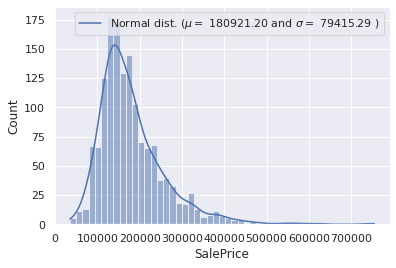

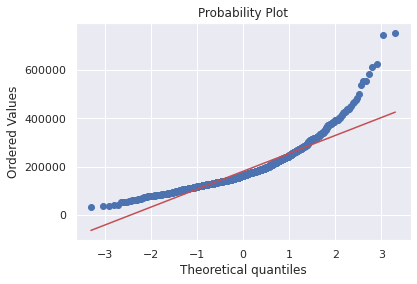

In [11]:
from scipy import stats

sns.histplot(train_raw['SalePrice'], kde=True)
mu, sigma = np.mean(train_raw['SalePrice']), np.std(train_raw['SalePrice'])
print( f'\n mu = {mu} and sigma = {sigma}\n')

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### We use the numpy fuction log1p which  applies log(1+x) to all elements of the column. The skew seems now corrected and the data appears more normally distributed


 mu = 12.02 and sigma = 0.40



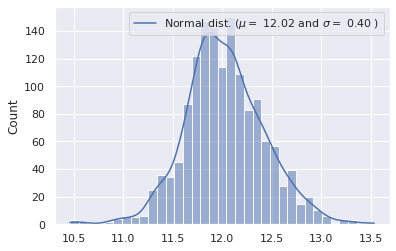

In [ ]:
y = np.log1p(y)
sns.histplot(y, kde=True)

mu, sigma = np.mean(y), np.std(y)
print( f'\n mu = {mu} and sigma = {sigma}\n')

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# Dataset splitting

In [ ]:
# print(combined_df.info())
train_df = combined_df.iloc[:1458]
test_df = combined_df.iloc[1458:]

features = train_df.columns
x = train_df[features].to_numpy()
x_test = test_df[features].to_numpy()

print(x.shape, y.shape)
# x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = int(0.999*len(train)), shuffle=False ,random_state=1400)
x_train = x
y_train = y
print(x_train.shape, y_train.shape)
print(x_test.shape)

(1458, 280) (1458,)
(1458, 280) (1458,)
(1459, 280)


# Modelling

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
  
rf = RandomForestRegressor(n_estimators = 100, criterion='mse', min_samples_leaf=5, random_state=1400)
rf.fit(x_train, y_train)

y_test = rf.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

test rmse(log):  0.1257881266130364
test rmse:  21827.86283691185


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

def rmse_cv(model, x, y, cv):    
    return np.sqrt(-cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv))

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics

elasticnet_alphas = [5e-5, 1e-4, 5e-4, 1e-3]
elasticnet_l1ratios = [0.8, 0.85, 0.9, 0.95, 1]

enet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=elasticnet_alphas,
                                        cv=kfolds, l1_ratio=elasticnet_l1ratios))

score = rmse_cv(enet, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

enet = enet.fit(x_train, y_train)
y_test = enet.predict(x_test)

print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.0838418  0.12627434 0.10796523 0.1103873  0.13254223 0.10438231
 0.12354277 0.09652744 0.10326098 0.09435238]
mean:  0.10830767735691885
test rmse(log):  0.10796293346734416
test rmse:  23776.062056519004


# Ridge(L2) Regression

In [ ]:

from sklearn.linear_model import Ridge, RidgeCV
from sklearn import metrics

alphas1 = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas1, cv=kfolds))
score= rmse_cv(ridge, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

ridge = ridge.fit(x_train, y_train)

y_test = ridge.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.09158063 0.13002978 0.10909069 0.10655015 0.13336154 0.10096571
 0.12645509 0.09986191 0.10283971 0.09170781]
mean:  0.10924430302450136
test rmse(log):  0.10714216489892507
test rmse:  24504.112214007204


# Lasso(L1) Regression

In [ ]:

from sklearn.linear_model import Lasso, LassoCV
from sklearn import metrics

alphas2 = [5e-5, 1e-4, 5e-4, 1e-3]

lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas2, cv=kfolds, max_iter=1e7, random_state=1400))

score= rmse_cv(lasso, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

lasso = lasso.fit(x_train, y_train)
y_test = lasso.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

# non_0 = [x for x in list(lasso.coef_) if x!=0]
# print(f'Lasso kept {len(non_0)} features & dropped {len(list(lasso.coef_))-len(non_0)}')

[0.0838418  0.12586913 0.10780194 0.1103873  0.13254223 0.10438231
 0.12300243 0.09604742 0.10326098 0.09435238]
mean:  0.10814879311053138
test rmse(log):  0.10796293346734416
test rmse:  23776.062056519004


# Support Vector Regressor

In [ ]:

from sklearn.svm import SVR
svr = make_pipeline(RobustScaler(), SVR(C=15, epsilon=0.008, gamma=0.0003)) 

score= rmse_cv(svr, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

svr = svr.fit(x_train, y_train)

y_test = svr.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.0977896  0.1594555  0.11619912 0.14534148 0.15147716 0.11658109
 0.14134579 0.11314143 0.12583324 0.10910958]
mean:  0.1276273998131423
test rmse(log):  0.11537892104826818
test rmse:  17160.147286116662


# Gradient Boosting Regressor
Gradient boosting works significantly better.

In [ ]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

gbr = GradientBoostingRegressor(n_estimators=4000,
                                learning_rate=0.015,
                                max_depth=5,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=1400)

score= rmse_cv(gbr, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

gbr = gbr.fit(x_train, y_train)

y_test = gbr.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.10518117 0.12649183 0.11013906 0.09592523 0.12987027 0.10516497
 0.13373428 0.11001785 0.11064757 0.08507912]
mean:  0.11122513641177507
test rmse(log):  0.10635824081474018
test rmse:  19413.07099831296


# xgboost XGBRegressor

In [ ]:

from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.01, n_estimators=6000,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1, seed=27,
                       reg_alpha=0.00006, random_state=42)

score= rmse_cv(xgb, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

xgb = xgb.fit(x_train, y_train)

y_test = xgb.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.10162893 0.12517708 0.10576613 0.10439514 0.12920768 0.10682506
 0.1227129  0.10648116 0.11567084 0.09358786]
mean:  0.11114527769290565
test rmse(log):  0.11143062210594983
test rmse:  20392.07491775346


# LGBMRegressor

In [ ]:

from lightgbm import LGBMRegressor

lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=1500,
                              max_bin = 200, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=42,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score= rmse_cv(lgb, x_train, y_train, kfolds)
print(score)
print('mean: ',score.mean())

lgb = lgb.fit(x_train, y_train)

y_test = lgb.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

[0.10923849 0.13161481 0.11286791 0.10051561 0.13466079 0.10569719
 0.13490103 0.11898194 0.10775464 0.09019392]
mean:  0.11464263415842375
test rmse(log):  0.10472569804467044
test rmse:  19315.476907739805


# StackingCV Regressor

In [ ]:

from mlxtend.regressor import StackingCVRegressor

stack = StackingCVRegressor(regressors=(ridge, lasso, svr, enet, gbr, xgb),
                                meta_regressor=gbr,
                                use_features_in_secondary=True)

stack = stack.fit(x_train, y_train)

y_test = stack.predict(x_test)
print('test rmse(log): ', np.sqrt(metrics.mean_squared_error(np.log1p(y_true), y_test)))
print('test rmse: ', np.sqrt(metrics.mean_squared_error(y_true, np.expm1(y_test))))

test rmse(log):  0.10491355274360667
test rmse:  17632.20932848996


# Ensembling with Model Blending

In [ ]:
blend_weights = [0.11, 0.05, 0.00, 0.14, 0.43, 0.00, 0.27]

y_pred = np.expm1((blend_weights[0] * enet.predict(x_train)) +
                  (blend_weights[1] * lasso.predict(x_train)) +
                  (blend_weights[2] * ridge.predict(x_train)) +
                  (blend_weights[3] * svr.predict(x_train)) +
                  (blend_weights[4] * gbr.predict(x_train)) +
                  (blend_weights[5] * xgb.predict(x_train)) +
                  (blend_weights[6] * stack.predict(x_train)))

rmse = np.sqrt(metrics.mean_squared_error(np.expm1(y_train), y_pred))
rmsle = np.sqrt(metrics.mean_squared_log_error(np.expm1(y_train), y_pred))
mae = metrics.mean_absolute_error(np.expm1(y_train), y_pred)
print('\nBlend model performance on the training set\n')
print(f'{"RMSE":<7} {rmse:>15.8f}')
print(f'{"RMSLE":<7} {rmsle:>15.8f}')
print(f'{"MAE":<7} {mae:>15.8f}')

print('\nGenerating submission')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/home-data-for-ml-course/sample_submission.csv')

submission.iloc[:, 1] = np.expm1((blend_weights[0] * enet.predict(x_test)) +
                  (blend_weights[1] * lasso.predict(x_test)) +
                  (blend_weights[2] * ridge.predict(x_test)) +
                  (blend_weights[3] * svr.predict(x_test)) +
                  (blend_weights[4] * gbr.predict(x_test)) +
                  (blend_weights[5] * xgb.predict(x_test)) +
                  (blend_weights[6] * stack.predict(x_test)))

submission.to_csv('my_submission.csv', index=False)
print('Submission saved')


Blend model performance on the training set

RMSE     10432.48413169
RMSLE        0.06371438
MAE       5856.52542979

Generating submission
Submission saved


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


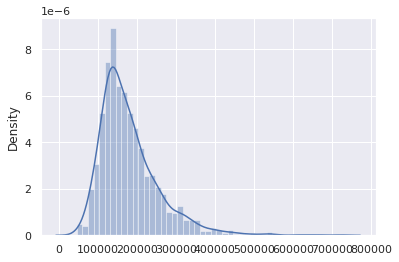

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


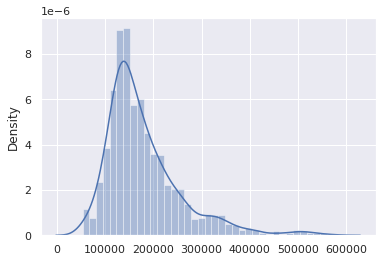

In [ ]:
y_test_pred = stack.predict(x_test)

sns.distplot(y_pred)
plt.show()
y_test_pred = np.expm1(y_test_pred)
sns.distplot(y_test_pred)
plt.show()

output = pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': y_test_pred})
output.to_csv('my_submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


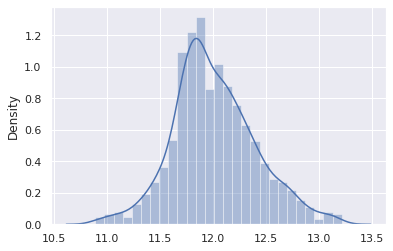

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


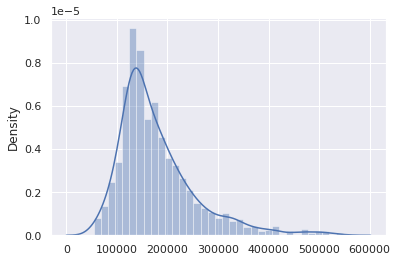

In [ ]:
def blend_models_predict(X):
 
    return ((0.05 * enet.predict(X)) + 
            (0.05 * lasso.predict(X)) + 
            (0.0 * ridge.predict(X)) + 
            (0.15 * svr.predict(X)) + 
            (0.4 * gbr.predict(X)) + 
            (0.0 * xgb.predict(X)) + 
            (0.05 * lgb.predict(X)) + 
            (0.3 * stack.predict(X)))
    
    
y_test_pred = blend_models_predict(x_test)

sns.distplot(y_test_pred)
plt.show()
y_test_pred = np.floor(np.expm1(y_test_pred))
sns.distplot(y_test_pred)
plt.show()

output = pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': y_test_pred})
output.to_csv('my_submission.csv', index=False)

# Averaging Base Models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


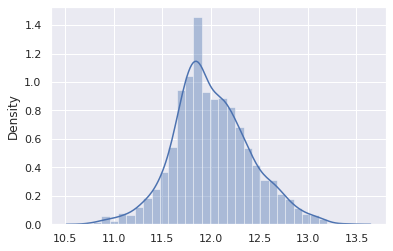

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


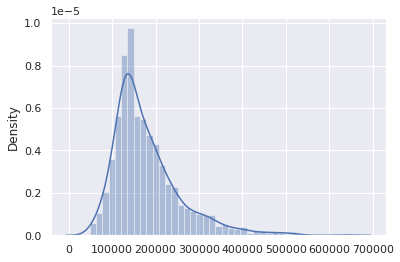

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self    

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

averaged_models = AveragingModels(models = (ridge, lasso, enet, svr, gbr, xgb, lgb))
averaged_models.fit(x_train, y_train)

y_test_pred = averaged_models.predict(x_test)

sns.distplot(y_test_pred)
plt.show()
y_test_pred = np.expm1(y_test_pred)
sns.distplot(y_test_pred)
plt.show()

output = pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': y_test_pred})
output.to_csv('my_submission.csv', index=False)